In [152]:
from statsmodels.regression import linear_model as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm2
from sklearn.metrics import r2_score
import scipy

In [153]:
#from google.colab import drive
#drive.mount('/content/drive')

In [154]:
import os
#os.chdir('/content/drive/MyDrive/Colab Notebooks')
l = []
for file in os.listdir():
  if "tsv" in file:
    l.append(file)


#**Association of Microstructural white matter and personality traits based on Human connectome project dataset**

In [155]:
csvfile = sorted(os.listdir())[1]
example = pd.read_csv(csvfile, sep =  '\t', index_col = 0)
col =example.columns
example[col[:]].head()
# first column (index of the pandas DataFrame): subjects ID

,tract,tags,number of tracts,mean length(mm),span(mm),curl,elongation,diameter(mm),volume(mm^3),trunk volume(mm^3),branch volume(mm^3),total surface area(mm^2),total radius of end regions(mm),total area of end regions(mm^2),irregularity,area of end region 1(mm^2),radius of end region 1(mm),irregularity of end region 1,area of end region 2(mm^2),radius of end region 2(mm),irregularity of end region 2,qa,nqa,dti_fa,md,ad,rd,gfa,iso,rdi,nrdi02L,nrdi04L,nrdi06L,Release,Acquisition,Gender,Gender.1,Age,Age.1,3T_Full_MR_Compl,...,NEORAW_31,NEORAW_32,NEORAW_33,NEORAW_34,NEORAW_35,NEORAW_36,NEORAW_37,NEORAW_38,NEORAW_39,NEORAW_40,NEORAW_41,NEORAW_42,NEORAW_43,NEORAW_44,NEORAW_45,NEORAW_46,NEORAW_47,NEORAW_48,NEORAW_49,NEORAW_50,NEORAW_51,NEORAW_52,NEORAW_53,NEORAW_54,NEORAW_55,NEORAW_56,NEORAW_57,NEORAW_58,NEORAW_59,NEORAW_60,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
100206,Arcuate_Fasciculus_L,dsi-studio-atk,19408.0,143.146,36.0387,3.97200,7.80815,18.3329,37786.0,30964.0,6822.0,66463.0,24.5641,6700.0,8.06158,3930.0,15.6829,0.196613,2770.0,8.88117,0.089456,0.220487,0.276894,0.423249,0.533732,0.790515,0.405684,0.136696,0.317688,0.305848,0.200755,0.026358,0.0,S900,Q11,M,2,26-30,28.0,1,...,N,N,D,A,A,N,A,N,D,N,N,D,D,A,A,N,N,N,A,N,N,A,A,D,N,D,N,D,A,N,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
100610,Arcuate_Fasciculus_L,dsi-studio-atk,17768.0,126.265,39.6110,3.18762,6.68010,18.9016,35430.0,34032.0,1398.0,59757.0,25.7529,6951.0,7.96998,3323.0,13.0736,0.161588,3628.0,12.67940,0.139212,0.205058,0.212183,0.354390,0.583224,0.810979,0.469420,0.123328,0.341505,0.319828,0.212939,0.029438,0.0,S900,Q08,M,2,26-30,28.0,1,...,SA,D,D,A,A,SD,D,N,A,A,SD,N,A,A,D,A,D,D,SA,A,SD,N,SA,SD,D,A,SA,SA,D,A,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
101006,Arcuate_Fasciculus_L,dsi-studio-atk,17162.0,118.315,29.9799,3.94649,5.63901,20.9816,40908.0,39282.0,1626.0,67965.0,25.5830,7279.0,8.71476,4310.0,15.2387,0.169265,2969.0,10.34430,0.113226,0.197688,0.234582,0.345588,0.556724,0.767215,0.451466,0.112722,0.363678,0.335583,0.223994,0.031119,0.0,S500,Q06,F,1,31-35,33.0,1,...,A,N,A,A,A,SD,A,A,SD,A,D,N,A,D,A,D,N,D,SA,SA,SD,A,N,N,SD,SD,N,N,SD,SA,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
101309,Arcuate_Fasciculus_L,dsi-studio-atk,19508.0,134.388,38.3946,3.50019,7.82612,17.1718,31123.0,24708.0,6415.0,56605.0,23.6644,6397.0,7.80779,4061.0,13.6400,0.143928,2336.0,10.02440,0.135143,0.182549,0.279228,0.414419,0.516641,0.755973,0.397166,0.127402,0.287287,0.274467,0.180802,0.024038,0.0,S500,Q06,M,2,26-30,28.0,1,...,SA,N,SD,SA,A,N,A,SA,N,SA,SD,N,SD,N,D,SA,N,A,SA,SA,SD,N,A,SD,D,SD,D,A,SD,A,5.2,122.25,110.45,0.0,38.6,106.39,104.39,1.80,0.0,1.80
101410,Arcuate_Fasciculus_L,dsi-studio-atk,17495.0,126.067,35.1831,3.58318,6.46317,19.5055,37671.0,26072.0,11599.0,68381.0,25.6253,6622.0,8.85168,2864.0,14.5607,0.232564,3758.0,11.06450,0.102343,0.171985,0.266361,0.376660,0.581214,0.819929,0.461950,0.127460,0.277252,0.261590,0.175235,0.024646,0.0,S500,Q06,M,2,26-30,28.0,0,...,A,N,D,A,A,D,N,D,D,N,D,N,D,N,D,A,N,D,SA,SA,SD,SA,A,D,D,D,N,N,D,SA,6.8,122.25,111.41,3.0,50.1,73.86,71.78,1.80,0.0,1.80


In [156]:
example[col[30:]].head()

,nrdi02L,nrdi04L,nrdi06L,Release,Acquisition,Gender,Gender.1,Age,Age.1,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,3T_tMRI_PctCompl,fMRI_WM_PctCompl,fMRI_Gamb_PctCompl,fMRI_Mot_PctCompl,fMRI_Lang_PctCompl,fMRI_Soc_PctCompl,fMRI_Rel_PctCompl,fMRI_Emo_PctCompl,3T_dMRI_Compl,3T_dMRI_PctCompl,dMRI_3T_ReconVrs,fMRI_3T_ReconVrs,7T_Full_MR_Compl,7T_RS-fMRI_Count,7T_RS-fMRI_PctCompl,7T_Full_Task_fMRI,7T_tMRI_PctCompl,fMRI_Movie_Compl,fMRI_Movie_PctCompl,fMRI_Ret_Compl,fMRI_Ret_PctCompl,7T_dMRI_Compl,7T_dMRI_PctCompl,7T_fMRI_Mov_Vrs,MEG_AnyData,...,NEORAW_31,NEORAW_32,NEORAW_33,NEORAW_34,NEORAW_35,NEORAW_36,NEORAW_37,NEORAW_38,NEORAW_39,NEORAW_40,NEORAW_41,NEORAW_42,NEORAW_43,NEORAW_44,NEORAW_45,NEORAW_46,NEORAW_47,NEORAW_48,NEORAW_49,NEORAW_50,NEORAW_51,NEORAW_52,NEORAW_53,NEORAW_54,NEORAW_55,NEORAW_56,NEORAW_57,NEORAW_58,NEORAW_59,NEORAW_60,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
100206,0.200755,0.026358,0.0,S900,Q11,M,2,26-30,28.0,1,1,1,4,100.0,1,100.0,100,100.0,100,100.0,100,100,100.0,1,100.0,r227,r227,0,0,0.0,0,0.0,0,0.0,0,0,0,0,NaN,0,...,N,N,D,A,A,N,A,N,D,N,N,D,D,A,A,N,N,N,A,N,N,A,A,D,N,D,N,D,A,N,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
100610,0.212939,0.029438,0.0,S900,Q08,M,2,26-30,28.0,1,2,1,4,100.0,1,100.0,100,100.0,100,100.0,100,100,100.0,1,100.0,r227,r227,1,4,100.0,1,100.0,1,100.0,1,100,1,100,2.0,0,...,SA,D,D,A,A,SD,D,N,A,A,SD,N,A,A,D,A,D,D,SA,A,SD,N,SA,SD,D,A,SA,SA,D,A,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
101006,0.223994,0.031119,0.0,S500,Q06,F,1,31-35,33.0,1,2,2,4,100.0,1,100.0,100,100.0,100,100.0,100,100,100.0,1,100.0,r227,r227,0,0,0.0,0,0.0,0,0.0,0,0,0,0,NaN,0,...,A,N,A,A,A,SD,A,A,SD,A,D,N,A,D,A,D,N,D,SA,SA,SD,A,N,N,SD,SD,N,N,SD,SA,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
101309,0.180802,0.024038,0.0,S500,Q06,M,2,26-30,28.0,1,1,1,4,100.0,1,100.0,100,100.0,100,100.0,100,100,100.0,1,100.0,r227,r227,0,0,0.0,0,0.0,0,0.0,0,0,0,0,NaN,0,...,SA,N,SD,SA,A,N,A,SA,N,SA,SD,N,SD,N,D,SA,N,A,SA,SA,SD,N,A,SD,D,SD,D,A,SD,A,5.2,122.25,110.45,0.0,38.6,106.39,104.39,1.80,0.0,1.80
101410,0.175235,0.024646,0.0,S500,Q06,M,2,26-30,28.0,0,2,1,2,50.0,1,100.0,100,100.0,100,100.0,100,100,100.0,1,100.0,r227,r227,0,0,0.0,0,0.0,0,0.0,0,0,0,0,NaN,0,...,A,N,D,A,A,D,N,D,D,N,D,N,D,N,D,A,N,D,SA,SA,SD,SA,A,D,D,D,N,N,D,SA,6.8,122.25,111.41,3.0,50.1,73.86,71.78,1.80,0.0,1.80


In [157]:
diff_labels = example.columns[example.columns.tolist().index("qa"):example.columns.tolist().index("rdi") + 1].tolist()
pers_labels = example.columns[example.columns.tolist().index("NEOFAC_A"):example.columns.tolist().index("NEOFAC_E") + 1].tolist()
diff_labels, pers_labels


#same as doing

#diff_labels = ["qa", "nqa", "dti_fa", "md", "ad", "rd", "gfa", "iso","rdi"]
#pers_labels = ["NEOFAC_A","NEOFAC_O", "NEOFAC_C", "NEOFAC_N", "NEOFAC_E"]

(['qa', 'nqa', 'dti_fa', 'md', 'ad', 'rd', 'gfa', 'iso', 'rdi'],
 ['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E'])

In [158]:
!pip install pingouin

In [159]:
import pingouin

## Linear regression

In [160]:
dic = {"pval": [], "coef" : [], "file" : [], "diff_labels":[], "pers_labels" : []}
pval = []
features = []
coef = []
intercept = []
xs = []
for file in sorted(os.listdir()):
  if "tsv" in file:
    fd = pd.read_csv(file, sep =  '\t', index_col = 0)
    for s in diff_labels:
      for l in pers_labels:
        x = fd[s]
        idx = np.where(np.isnan(x))
        y = fd[l]
        idx2 = np.where(np.isnan(y)) 
        x = np.delete(np.array(x),idx2[0].tolist()+ idx[0].tolist())
        y = np.delete(np.array(y),idx2[0].tolist()+ idx[0].tolist())
        x2 = sm2.add_constant(x)
        ls = sm.OLS(y, x2).fit()
        pval.append(ls.pvalues[1])
        dic["pval"].append(ls.pvalues[1])
        coef.append(ls.params[1])
        dic["coef"].append(ls.params[1])
        intercept.append(ls.params[0])
        features.append([file,s,l])
        dic["file"].append(file)
        dic["diff_labels"].append(s)
        dic["pers_labels"].append(l)
        # here make a dictionary

In [161]:
files = np.array(features)[np.array(pval) < 0.0007]
len(files)

37

In [162]:
id = pval.index(min(pval))
pval[id]

1.447933784055021e-06

In [163]:
features[id]

['Cingulum_Parahippocampal_L siblings.tsv', 'ad', 'NEOFAC_A']

In [164]:
for r in range(len(files)):
  f = files[r][0]
  s = files[r][1]
  l = files[r][2]
  if l == "NEOFAC_A":
    l2 = "Agreeableness"
  elif l == "NEOFAC_O":
    l2 = "Openness to experience"
  elif l == "NEOFAC_E":
    l2 = "Extraversion"
  elif l == "NEOFAC_C":
    l2 = "Coscientiousness"
  else:
    l2 = "Neuroticism"
  fd = pd.read_csv(f, sep =  '\t', index_col = 0)
  index = ["Slope coefficient","P-value","R2"]
  variable = "Tract: %s, Variables: %s vs %s" %(files[r][0][:-4],l2, s)
  if r == 0:
    table1 = pd.DataFrame(columns = index)
  
  x = fd[s]
  y = fd[l] 
  idx = np.where(np.isnan(x))
  idx2 = np.where(np.isnan(y))
  y = np.delete(np.array(y),idx2[0].tolist()+ idx[0].tolist())
  x = np.delete(np.array(x),idx2[0].tolist()+ idx[0].tolist())
  
  x = (x- np.mean(x))/np.std(x) # z-score
  y = (y- np.mean(y))/np.std(y) # z-score
  x2 = sm2.add_constant(x)
  ls = sm.OLS(y, x2).fit()

  table1.loc[variable] = [0,0,0]

  table1[index[0]][variable] = "%.2f +- %.2f" %(round(ls.params[1],2),round(ls.bse[1],2))
  table1[index[1]][variable] = round(ls.pvalues[1],4)
  table1[index[2]][variable] = r"%.2f %%" %round(r2_score(y,ls.params[0] + ls.params[1]*x)*100,2)

In [165]:
table1

,Slope coefficient,P-value,R2
"Tract: Cingulum_Frontal_Parahippocampal_R siblings, Variables: Agreeableness vs ad",0.14 +- 0.04,0.0004,2.00 %
"Tract: Cingulum_Parahippocampal_L siblings, Variables: Agreeableness vs qa",0.15 +- 0.04,0.0001,2.39 %
"Tract: Cingulum_Parahippocampal_L siblings, Variables: Agreeableness vs ad",0.19 +- 0.04,0,3.67 %
"Tract: Cingulum_Parahippocampal_Parietal_L siblings, Variables: Agreeableness vs ad",0.14 +- 0.04,0.0003,2.05 %
"Tract: Cingulum_Parahippocampal_R siblings, Variables: Agreeableness vs ad",0.15 +- 0.04,0.0001,2.29 %
"Tract: Corpus_Callosum_Body siblings, Variables: Agreeableness vs ad",0.14 +- 0.04,0.0003,2.10 %
"Tract: Corticobulbar_Tract_L siblings, Variables: Agreeableness vs ad",0.14 +- 0.04,0.0006,1.95 %
"Tract: Corticobulbar_Tract_R siblings, Variables: Agreeableness vs ad",0.17 +- 0.04,0,2.88 %
"Tract: Corticobulbar_Tract_R siblings, Variables: Agreeableness vs gfa",0.16 +- 0.04,0.0001,2.67 %
"Tract: Corticopontine_Tract_Frontal_L siblings, Variables: Agreeableness vs dti_fa",0.16 +- 0.04,0.0001,2.50 %


In [166]:
scipy.stats.spearmanr(x,y)

SpearmanrResult(correlation=0.15070121100789266, pvalue=0.00015967019182563493)

In [167]:
np.corrcoef(x,y)[0,1]

0.15546066116927376

In [168]:
ls.params[1]*np.std(x)/np.std(y)

0.15546066116927376

In [169]:
ls.params[1]*np.std(x)/np.std(y)

0.15546066116927376

## Taking into account some covariates

In [170]:
import pingouin

In [171]:
pvals = []
corrs = []
features = []
for file in sorted(os.listdir()):
  if "tsv" in file:
    #print(file)
    fd = pd.read_csv(file, sep =  '\t', index_col = 0)
    for s in pers_labels:
      for l in diff_labels:
        rs = pingouin.partial_corr(fd,s,l, ["Gender.1", "Age.1"])
        corrs.append(rs['r'][0])
        pvals.append(rs['p-val'][0])
        features.append([file,s,l])

In [172]:

ins = np.argsort(pvals)[:5]

In [173]:
rs

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,623,0.055163,"[-0.02, 0.13]",0.003043,-0.000173,0.169084,0.129,0.27999


In [174]:
for i in ins:
  print(pvals[i], corrs[i], features[i])

0.00018081380706236268 0.14947347488614868 ['Superior_Longitudinal_Fasciculus2_L siblings.tsv', 'NEOFAC_A', 'ad']
0.0007743848402174965 0.13434609764864186 ['Superior_Longitudinal_Fasciculus3_L siblings.tsv', 'NEOFAC_A', 'ad']
0.001977644947834402 0.12391156990876531 ['Corticopontine_Tract_Frontal_R siblings.tsv', 'NEOFAC_A', 'ad']
0.003143417576119482 0.11814622488092139 ['Corticostriatal_Tract_Superior_L siblings.tsv', 'NEOFAC_A', 'ad']
0.00365612500666608 0.1162807956773348 ['Superior_Longitudinal_Fasciculus1_L siblings.tsv', 'NEOFAC_A', 'ad']


## Multiple Linear Model

In [175]:
def ordinary_least_squares(Xc, y):

  """ 
  Function that computes OLS analytically

  NB: to take into account also an intercept, a constant vector of 1 needs to be included in Xc.
  then theta_hat will contain both the results for the intercept and the result for the coefficients

  Equivalent to python functions:
  from sklearn.linear_model import LinearRegression
  model = LinearRegression() 
  model.fit(X,y) 
  or
  from statsmodels.regression import linear_model as sm
  sm.OLS(y,Xc).fit()

  Xc (ndarray): design matrix of shape (n_samples, n_regressors)
  y (ndarray): vector of measurements of shape (n_samples)
  Returns:
  ndarray: estimated parameter values of shape (n_regressors)
  """


  # Compute theta_hat using OLS
  theta_hat = np.linalg.inv(Xc.T @ Xc) @ Xc.T @ y

  return theta_hat



In [176]:
from sklearn.linear_model import LinearRegression

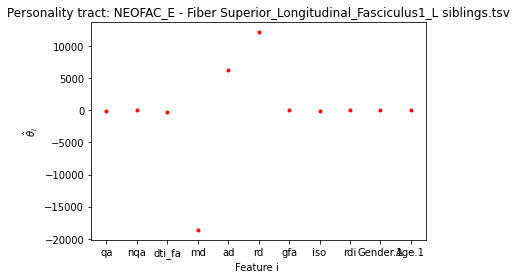

In [177]:

for r in range(len(files)):
  f = files[r][0]

  fd = pd.read_csv(f, sep =  '\t', index_col = 0)
  col = diff_labels + ["Gender.1"] + ["Age.1"] 
  X = fd[col]
  for t in pers_labels:

    y = fd[t]

    model = LinearRegression()
    idx2 = np.where(np.isnan(y))
    y = np.array(y)
    y = np.delete(y,idx2[0])

    X = np.array(X)
    Xnew = np.empty((X.shape[0]-1,X.shape[1]))
  
    for l in range(len(X[0])):
      Xnew[:,l] = np.delete(X[:,l], idx2[0])

    Xnew2 = sm2.add_constant(Xnew)
    model.fit(Xnew,y)
    theta_hat = ordinary_least_squares(Xnew2, y)

    y_hat = Xnew2 @ theta_hat
    # Compute MSE
    
    #print('Personality tract:', t)
    #print(model.score(Xnew,y)*100)
    #print(f"MSE = {np.mean((y - y_hat)**2):.2f}") 

plt.figure()
plt.title('Personality tract: %s - Fiber %s' %(t,f))
plt.plot(model.coef_, 'r.')
plt.xlabel('Feature i ')
plt.ylabel(r'$\hat{\theta}_i$')
plt.xticks(np.arange(0,len(col),1), labels = col);


In [178]:
print(col)

['qa', 'nqa', 'dti_fa', 'md', 'ad', 'rd', 'gfa', 'iso', 'rdi', 'Gender.1', 'Age.1']


In [179]:
for r in np.argsort(np.abs(model.coef_))[::-1][:3]:
  print(col[r])

md
rd
ad


qa nqa


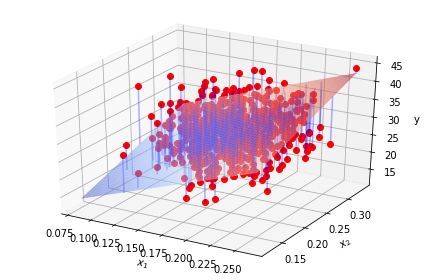

In [180]:
# Plotting the fit of the multiple linear model on two chosen directions

# contigous indexes
idx1 = 0
idx2 = 1
print(col[idx1], col[idx2])
theta_hat = ordinary_least_squares(Xnew2, y)
x_pred = np.linspace(min(Xnew2[:,1+idx1]),max(Xnew2[:,1+idx1]), 50)   
y_pred = np.linspace(min(Xnew2[:,1+idx2]),max(Xnew2[:,1+idx2]), 50)  
xx, yy = np.meshgrid(x_pred, y_pred)
theta_hat = ordinary_least_squares(Xnew2[:,1+idx1:2+idx2], y)
y_hat_grid = np.array([xx.flatten(), yy.flatten()]).T @ theta_hat
ypred = Xnew2[:,1+idx1:1+idx2+1] @ theta_hat
y_hat_grid = y_hat_grid.reshape((50, 50))
model_viz = np.array([xx.flatten(), yy.flatten()]).T
from sklearn import linear_model
ols = linear_model.LinearRegression()
model = ols.fit(Xnew[:,idx1:idx2+1], y)
ax = plt.subplot(projection='3d')

ax.plot(Xnew2[:, 1+idx1], Xnew2[:, 1+idx2], y, 'ro')
ax.plot_surface(xx, yy, y_hat_grid.reshape(50,50), linewidth=0, alpha=0.5, color='C1',
                cmap=plt.get_cmap('coolwarm'))

ax.set(
    xlabel='$x_1$',
    ylabel='$x_2$',
    zlabel='y'

)
for i in range(len(Xnew2)):
  ax.plot((Xnew2[i, 1+idx1], Xnew2[i, 1+idx1]),
          (Xnew2[i, 1+idx2], Xnew2[i, 1+ idx2]),
          (y[i], ypred[i]),
          'b-', alpha=.3)

plt.tight_layout()


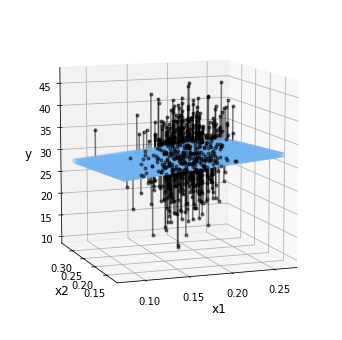

In [181]:
# Plotting the fit of the multiple linear model on two chosen directions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D

x1 = Xnew[:,0]
x2 = Xnew[:,1]
x_pred = np.linspace(min(x1),max(x1), 50)   
y_pred = np.linspace(min(x2),max(x2), 50) 
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T
Y = y
z = Y
from sklearn import linear_model
ols = linear_model.LinearRegression()
model = ols.fit(Xnew[:,:2], Y)
predicted = model.predict(model_viz)
ypred = model.predict(Xnew[:,:2])
fig = plt.figure(figsize = (20,6))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(x1,x2, z, color='k', zorder=15, linestyle='none', marker='.', alpha=0.5)
ax1.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
ax1.locator_params(nbins=4, axis='x')
ax1.set_xlabel('x1', fontsize=12)
ax1.set_ylabel('x2', fontsize=12)
ax1.set_zlabel('y', fontsize=12)
ax1.locator_params(nbins=5, axis='x')

for i in range(len(Xnew2)):
  ax1.plot((Xnew2[i, 1+idx1], Xnew2[i, 1+idx1]),
          (Xnew2[i, 1+idx2], Xnew2[i, 1+ idx2]),
          (y[i], ypred[i]),
          'k-', alpha=.5)
ax1.view_init(elev=10, azim=250)

## Replicating the method on shape features (e. g. 'span(mm)', 'curl', 'elongation', 'diameter(mm)', 'volume(mm^3)', 'trunk volume(mm^3)', 'branch volume(mm^3)', 'total surface area(mm^2)', 'total radius of end regions(mm) etc...)

In [182]:
shape_labels = fd.columns[fd.columns.tolist().index("span(mm)"):fd.columns.tolist().index('irregularity of end region 2')+1]

In [183]:
shape_labels

Index(['span(mm)', 'curl', 'elongation', 'diameter(mm)', 'volume(mm^3)',
       'trunk volume(mm^3)', 'branch volume(mm^3)', 'total surface area(mm^2)',
       'total radius of end regions(mm)', 'total area of end regions(mm^2)',
       'irregularity', 'area of end region 1(mm^2)',
       'radius of end region 1(mm)', 'irregularity of end region 1',
       'area of end region 2(mm^2)', 'radius of end region 2(mm)',
       'irregularity of end region 2'],
      dtype='object')

In [184]:
pval = []
features = []
coef = []
intercept = []
xs = []
for file in sorted(os.listdir()):
  if "tsv" in file:
    #print(file)
    fd = pd.read_csv(file, sep =  '\t', index_col = 0)
    for s in shape_labels:
      for l in pers_labels:
        x = fd[s]
        idx = np.where(np.isnan(x))
        y = fd[l]
        idx2 = np.where(np.isnan(y)) 
        x = np.delete(np.array(x),idx2[0].tolist()+ idx[0].tolist())
        y = np.delete(np.array(y),idx2[0].tolist()+ idx[0].tolist())
        x2 = sm2.add_constant(x)
        ls = sm.OLS(y, x2).fit()
        pval.append(ls.pvalues[1])
        coef.append(ls.params[1])
        intercept.append(ls.params[0])
        xs.append(x)
        features.append([file,s,l])

In [185]:
files = np.array(features)[np.array(pval) < 0.0007]
len(files)

25

In [186]:
id = pval.index(min(pval))
pval[id]

1.6076051633996757e-05

In [187]:

for r in range(len(files)):
  


  f = files[r][0]
  s = files[r][1]
  l = files[r][2]
  fd = pd.read_csv(f, sep =  '\t', index_col = 0)
  x = fd[s]
  y = fd[l] 


  index = ["Slope coefficient","P-value","R2"]


  if l == "NEOFAC_A":
    l2 = "Agreeableness"
  elif l == "NEOFAC_O":
    l2 = "Openness to experience"
  elif l == "NEOFAC_E":
    l2 = "Extraversion"
  elif l == "NEOFAC_C":
    l2 = "Coscientiousness"
  else:
    l2 = "Neuroticism"

  variable = "Tract: %s, Variables: %s vs %s" %(files[r][0][:-4],l2, s)

  if r == 0:
    table1 = pd.DataFrame(columns = index)

  idx = np.where(np.isnan(x))
  idx2 = np.where(np.isnan(y))
  
  
  y = np.delete(np.array(y),idx2[0].tolist()+ idx[0].tolist())
  x = np.delete(np.array(x),idx2[0].tolist()+ idx[0].tolist())

  x = (x- np.mean(x))/np.std(x) # z-score
  y = (y- np.mean(y))/np.std(y) # z-score
  x2 = sm2.add_constant(x)
  ls = sm.OLS(y, x2).fit()

  table1.loc[variable] = [0,0,0]

  table1[index[0]][variable] = "%.2f +- %.2f" %(round(ls.params[1],2),round(ls.bse[1],2))
  table1[index[1]][variable] = round(ls.pvalues[1],10)
  table1[index[2]][variable] = r"%.2f %%" %round(r2_score(y,ls.params[0] + ls.params[1]*x)*100,2)


In [188]:
len(files)

25

In [189]:
table1

,Slope coefficient,P-value,R2
"Tract: Arcuate_Fasciculus_L siblings, Variables: Coscientiousness vs radius of end region 1(mm)",-0.14 +- 0.04,0.000442178,1.97 %
"Tract: Corpus_Callosum_Forceps_Minor siblings, Variables: Coscientiousness vs branch volume(mm^3)",-0.15 +- 0.04,0.000151961,2.29 %
"Tract: Corticopontine_Tract_Frontal_R siblings, Variables: Neuroticism vs total area of end regions(mm^2)",-0.14 +- 0.04,0.000538302,1.92 %
"Tract: Corticopontine_Tract_Frontal_R siblings, Variables: Coscientiousness vs irregularity of end region 1",-0.14 +- 0.04,0.00051855,1.93 %
"Tract: Corticopontine_Tract_Occipital_L siblings, Variables: Extraversion vs total radius of end regions(mm)",0.15 +- 0.04,0.000439272,2.30 %
"Tract: Corticostriatal_Tract_Anterior_L siblings, Variables: Agreeableness vs span(mm)",-0.14 +- 0.04,0.000284738,2.10 %
"Tract: Corticostriatal_Tract_Anterior_L siblings, Variables: Agreeableness vs area of end region 1(mm^2)",-0.15 +- 0.04,0.000254725,2.13 %
"Tract: Corticostriatal_Tract_Anterior_R siblings, Variables: Agreeableness vs span(mm)",-0.15 +- 0.04,0.00010393,2.40 %
"Tract: Corticostriatal_Tract_Anterior_R siblings, Variables: Agreeableness vs area of end region 1(mm^2)",-0.17 +- 0.04,1.60761e-05,2.95 %
"Tract: Corticostriatal_Tract_Posterior_R siblings, Variables: Agreeableness vs span(mm)",-0.14 +- 0.04,0.000374745,2.02 %


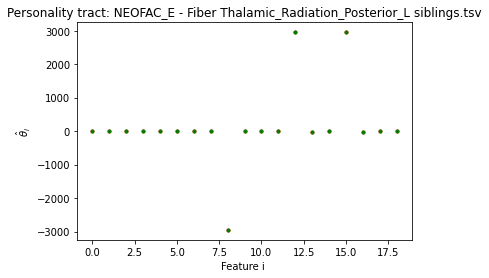

In [190]:
#Multiple Linear Model
for r in range(len(files)):
  #print('Tract', files[r][0])
  f = files[r][0]
  fd = pd.read_csv(f, sep =  '\t', index_col = 0)
  col = shape_labels.tolist() + ["Gender.1"] + ["Age.1"]

  X = fd[col]
  for t in pers_labels:
    
    y = fd[t]

    model = LinearRegression()
    idx2 = np.where(np.isnan(y))

    y = np.array(y)
    y = np.delete(y,idx2[0])

    X = np.array(X)
    Xnew = np.empty((X.shape[0]-1,X.shape[1]))

    for l in range(len(X[0])):
      Xnew[:,l] = np.delete(X[:,l], idx2[0])
  
    Xnew2 = sm2.add_constant(Xnew)

    model.fit(Xnew,y)

    theta_hat = ordinary_least_squares(Xnew2,y)

    y_hat = Xnew2 @ theta_hat
    ols = sm.OLS(y, Xnew2).fit()

    
    
    #print('Personality tract:', t)
    #print(model.score(Xnew,y)*100)
    #print(f"MSE = {np.mean((y - y_hat)**2):.2f}") 


plt.figure()
plt.title('Personality tract: %s - Fiber %s' %(t,f))
plt.plot(model.coef_, 'r.')
plt.plot(ols.params[1:], 'g.')
#plt.xticks(np.arange(0,len(col),1), labels = col)
plt.xlabel('Feature i ')
plt.ylabel(r'$\hat{\theta}_i$');

In [191]:
for r in np.argsort(np.abs(model.coef_))[::-1][:3]:
          print(col[r])

radius of end region 2(mm)
radius of end region 1(mm)
total radius of end regions(mm)


## Females

In [192]:
pval = []
features = []
coef = []
intercept = []
xs = []
for file in sorted(os.listdir()):
  if "tsv" in file:
    fd = pd.read_csv(file, sep =  '\t', index_col = 0)
    males = []
    females = []  
    gender = np.array(fd["Gender.1"])
    for r in range(len(gender)):
      if gender[r] == 1:
        females.append(fd.index[r])


    #for r in range(len(gender)):
     # if gender[r] == 2:
      #  males.append(fd.index[r])


    #maledf = df.loc[males]
    femaledf = fd.loc[females]
    #print(len(femaledf))
    for s in diff_labels:
      for l in pers_labels:
        x = femaledf[s]
        idx = np.where(np.isnan(x))
        y = femaledf[l]
        idx2 = np.where(np.isnan(y)) 
        x = np.delete(np.array(x),idx2[0].tolist()+ idx[0].tolist())
        y = np.delete(np.array(y),idx2[0].tolist()+ idx[0].tolist())
        x2 = sm2.add_constant(x)
        ls = sm.OLS(y, x2).fit()
        pval.append(ls.pvalues[1])
        coef.append(ls.params[1])
        intercept.append(ls.params[0])
        xs.append(x)
        features.append([file,s,l])

In [193]:
files = np.array(features)[np.array(pval) < 0.0007]
files
#p = np.array(pval)[np.array(pval) < 0.005]

array([], shape=(0, 3), dtype='<U51')

In [194]:
files = np.array(features)[np.array(pval) < 0.007]
files
#p = np.array(pval)[np.array(pval) < 0.005]

array([['Corticobulbar_Tract_R siblings.tsv', 'gfa', 'NEOFAC_A'],
       ['Corticopontine_Tract_Frontal_R siblings.tsv', 'ad', 'NEOFAC_A'],
       ['Dentatorubrothalamic_Tract_R siblings.tsv', 'dti_fa',
        'NEOFAC_A'],
       ['Dentatorubrothalamic_Tract_R siblings.tsv', 'gfa', 'NEOFAC_A'],
       ['Inferior_Longitudinal_Fasciculus_L siblings.tsv', 'gfa',
        'NEOFAC_A'],
       ['Superior_Longitudinal_Fasciculus1_L siblings.tsv', 'ad',
        'NEOFAC_A'],
       ['Superior_Longitudinal_Fasciculus2_L siblings.tsv', 'ad',
        'NEOFAC_A']], dtype='<U51')

In [195]:
for r in range(len(files)):
  f = files[r][0]
  fd = pd.read_csv(f, sep =  '\t', index_col = 0)
  males = []
  females = []  
  gender = np.array(fd["Gender.1"])
  for h in range(len(gender)):
    if gender[h] == 1:
      females.append(fd.index[h])


  #for r in range(len(gender)):
    # if gender[r] == 2:
    #  males.append(fd.index[r])


  #maledf = df.loc[males]
  
  femaledf = fd.loc[females]

  s = files[r][1]
  l = files[r][2]


  
  index = ["Slope coefficient","P-value","R2"]


  if l == "NEOFAC_A":
    l2 = "Agreeableness"
  elif l == "NEOFAC_O":
    l2 = "Openness to experience"
  elif l == "NEOFAC_E":
    l2 = "Extraversion"
  elif l == "NEOFAC_C":
    l2 = "Coscientiousness"
  else:
    l2 = "Neuroticism"

  variable = "Tract: %s, Variables: %s vs %s" %(files[r][0][:-4],l2, s)

  if r == 0:
    table1 = pd.DataFrame(columns = index)

  x = femaledf[s]
  y = femaledf[l] 
  idx = np.where(np.isnan(x))
  idx2 = np.where(np.isnan(y))
  y = np.delete(np.array(y),idx2[0].tolist()+ idx[0].tolist())
  x = np.delete(np.array(x),idx2[0].tolist()+ idx[0].tolist())
  #x = np.delete(np.array(x),13) # outlier in Cingulum_Parahippocampal_R case
  #y = np.delete(np.array(y),13) #outlier in Cingulum_Parahippocampal_R case
  x = (x- np.mean(x))/np.std(x) # z-score
  y = (y- np.mean(y))/np.std(y) # z-score
  x2 = sm2.add_constant(x)
  ls = sm.OLS(y, x2).fit()


  table1.loc[variable] = [0,0,0]

  table1[index[0]][variable] = "%.2f +- %.2f" %(round(ls.params[1],2),round(ls.bse[1],2))
  table1[index[1]][variable] = round(ls.pvalues[1],4)
  table1[index[2]][variable] = r"%.2f %%" %round(r2_score(y,ls.params[0] + ls.params[1]*x)*100,2)


In [196]:
table1

,Slope coefficient,P-value,R2
"Tract: Corticobulbar_Tract_R siblings, Variables: Agreeableness vs gfa",0.17 +- 0.06,0.0032,2.73 %
"Tract: Corticopontine_Tract_Frontal_R siblings, Variables: Agreeableness vs ad",0.16 +- 0.05,0.0027,2.72 %
"Tract: Dentatorubrothalamic_Tract_R siblings, Variables: Agreeableness vs dti_fa",0.16 +- 0.05,0.0037,2.56 %
"Tract: Dentatorubrothalamic_Tract_R siblings, Variables: Agreeableness vs gfa",0.16 +- 0.05,0.0043,2.48 %
"Tract: Inferior_Longitudinal_Fasciculus_L siblings, Variables: Agreeableness vs gfa",0.16 +- 0.05,0.0044,2.46 %
"Tract: Superior_Longitudinal_Fasciculus1_L siblings, Variables: Agreeableness vs ad",0.16 +- 0.05,0.0033,2.62 %
"Tract: Superior_Longitudinal_Fasciculus2_L siblings, Variables: Agreeableness vs ad",0.16 +- 0.05,0.0035,2.59 %


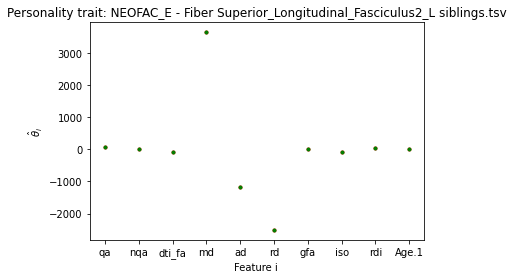

In [197]:
#Multiple Linear Model
for r in range(len(files)):


  f = files[r][0]
  fd = pd.read_csv(f, sep =  '\t', index_col = 0)

  #males = []
  females = []  
  gender = np.array(fd["Gender.1"])
  for g in range(len(gender)):

    if gender[g] == 1:
      females.append(fd.index[g])


  #for r in range(len(gender)):
    # if gender[r] == 2:
    #  males.append(fd.index[r])
    
  
  col = diff_labels + ["Age.1"]
  femaledf = fd.loc[females]
  X = femaledf[col]
  for t in pers_labels:
    
    
    y = femaledf[t]

    model = LinearRegression()


    idx2 = np.where(np.isnan(y))

    y = np.array(y)
    if np.any(idx2):
      y = np.delete(y,idx2[0])

    X = np.array(X)
    Xnew = np.copy(X)
    #print(X.shape, Xnew.shape)
    if np.any(idx2):
    
      Xnew = np.empty((X.shape[0]-1, X.shape[1]))
      for l in range(len(X[0])):
        Xnew[:,l] = np.delete(X[:,l], idx2[0])
    else:
      Xnew = X.copy()

    Xnew2 = sm2.add_constant(Xnew)

    model.fit(Xnew,y)

    theta_hat = ordinary_least_squares(Xnew2,y)

    y_hat = Xnew2 @ theta_hat
    ols = sm.OLS(y, Xnew2).fit()

      
      

plt.figure()
plt.title('Personality trait: %s - Fiber %s' %(t,f))
plt.plot(model.coef_, 'r.')
plt.plot(ols.params[1:], 'g.')
plt.xticks(np.arange(0,len(col),1), labels = col)
plt.xlabel('Feature i ')
plt.ylabel(r'$\hat{\theta}_i$');

In [198]:
np.any([])

False

## Males

In [199]:
pval = []
features = []
coef = []
intercept = []
xs = []
for file in sorted(os.listdir()):
  if "tsv" in file:
   
    fd = pd.read_csv(file, sep =  '\t', index_col = 0)
    males = []
    females = []  
    gender = np.array(fd["Gender.1"])
    #for r in range(len(gender)):
      #if gender[r] == 1:
        #females.append(fd.index[r])


    for r in range(len(gender)):
      if gender[r] == 2:
        males.append(fd.index[r])


    maledf = fd.loc[males]
    #femaledf = df.loc[females]
    for s in diff_labels:
      for l in pers_labels:
        x = maledf[s]
        idx = np.where(np.isnan(x))
        y = maledf[l]
        idx2 = np.where(np.isnan(y)) 
        x = np.delete(np.array(x),idx2[0].tolist()+ idx[0].tolist())
        y = np.delete(np.array(y),idx2[0].tolist()+ idx[0].tolist())
        x2 = sm2.add_constant(x)
        ls = sm.OLS(y, x2).fit()
        pval.append(ls.pvalues[1])
        coef.append(ls.params[1])
        intercept.append(ls.params[0])
        xs.append(x)
        features.append([file,s,l])

In [200]:
filess = np.array(features)[np.array(pval) < 0.0005]
filess

array([['Vertical_Occipital_Fasciculus_R siblings.tsv', 'gfa',
        'NEOFAC_N']], dtype='<U51')

In [201]:
files = np.array(features)[np.array(pval) < 0.007]
files

array([['Inferior_Cerebellar_Peduncle_R siblings.tsv', 'rd', 'NEOFAC_E'],
       ['Middle_Cerebellar_Peduncle siblings.tsv', 'dti_fa', 'NEOFAC_E'],
       ['Middle_Cerebellar_Peduncle siblings.tsv', 'gfa', 'NEOFAC_E'],
       ['Vertical_Occipital_Fasciculus_R siblings.tsv', 'dti_fa',
        'NEOFAC_N'],
       ['Vertical_Occipital_Fasciculus_R siblings.tsv', 'gfa',
        'NEOFAC_N']], dtype='<U51')

In [202]:
for r in range(len(files)):
  f = files[r][0]
  fd = pd.read_csv(f, sep =  '\t', index_col = 0)
  males = []
  females = []  
  gender = np.array(fd["Gender.1"])
  for h in range(len(gender)):
    if gender[h] == 2:
      males.append(fd.index[h])


  #for r in range(len(gender)):
    # if gender[r] == 2:
    #  males.append(fd.index[r])


  #maledf = df.loc[males]
  maledf = fd.loc[males]

  s = files[r][1]
  l = files[r][2]



  index = ["Slope coefficient","P-value","R2"]


  if l == "NEOFAC_A":
    l2 = "Agreeableness"
  elif l == "NEOFAC_O":
    l2 = "Openness to experience"
  elif l == "NEOFAC_E":
    l2 = "Extraversion"
  elif l == "NEOFAC_C":
    l2 = "Coscientiousness"
  else:
    l2 = "Neuroticism"

  variable = "Tract: %s, Variables: %s vs %s" %(files[r][0][:-4],l2, s)

  if r == 0:
    table1 = pd.DataFrame(columns = index)

  x = maledf[s]
  y = maledf[l] 
  idx = np.where(np.isnan(x))
  idx2 = np.where(np.isnan(y))
  y = np.delete(np.array(y),idx2[0].tolist()+ idx[0].tolist())
  x = np.delete(np.array(x),idx2[0].tolist()+ idx[0].tolist())
  x = (x- np.mean(x))/np.std(x) # z-score
  y = (y- np.mean(y))/np.std(y) # z-score
  x2 = sm2.add_constant(x)
  ls = sm.OLS(y, x2).fit()


  table1.loc[variable] = [0,0,0]

  table1[index[0]][variable] = "%.2f +- %.2f" %(round(ls.params[1],2),round(ls.bse[1],2))
  table1[index[1]][variable] = round(ls.pvalues[1],4)
  table1[index[2]][variable] = r"%.2f %%" %round(r2_score(y,ls.params[0] + ls.params[1]*x)*100,2)
  """
  print('R2: ', r2_score(y,ls.params[0] + ls.params[1]*x)*100, '%')
  plt.figure()
  plt.plot(x, ls.params[0] + ls.params[1]*x, 'r-')
  
  print('Slope coeff and pvalue: ',ls.params[1], ls.pvalues[1])
  ls.summary()
  plt.title(f)
  plt.plot(x,y, 'b.')
  plt.ylabel(l)
  plt.xlabel(s)
  plt.show()
  """

In [203]:
table1

,Slope coefficient,P-value,R2
"Tract: Inferior_Cerebellar_Peduncle_R siblings, Variables: Extraversion vs rd",-0.17 +- 0.06,0.004,2.79 %
"Tract: Middle_Cerebellar_Peduncle siblings, Variables: Extraversion vs dti_fa",0.18 +- 0.06,0.0015,3.37 %
"Tract: Middle_Cerebellar_Peduncle siblings, Variables: Extraversion vs gfa",0.17 +- 0.06,0.0042,2.77 %
"Tract: Vertical_Occipital_Fasciculus_R siblings, Variables: Neuroticism vs dti_fa",-0.16 +- 0.06,0.0063,2.52 %
"Tract: Vertical_Occipital_Fasciculus_R siblings, Variables: Neuroticism vs gfa",-0.21 +- 0.06,0.0002,4.48 %


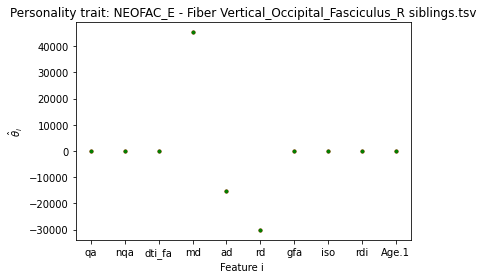

In [215]:
#Multiple Linear Model
for r in range(len(files)):
  
  f = files[r][0]
  fd = pd.read_csv(f, sep =  '\t', index_col = 0)

  males = []
  gender = np.array(fd["Gender.1"])

  for g in range(len(np.array(gender))):
  
    if gender[g] == 2:
      males.append(fd.index[g])
  col = diff_labels + ["Age.1"]
  maledf = fd.loc[males]
  X = maledf[col]
  for t in pers_labels:
    y = maledf[t]
    model = LinearRegression()
    idx2 = np.where(np.isnan(y))
    y = np.array(y)
    X = np.array(X)
    Xnew = np.copy(X)
    #print(X.shape, Xnew.shape)
    

    Xnew2 = sm2.add_constant(Xnew)

    model.fit(Xnew,y)

    theta_hat = ordinary_least_squares(Xnew2,y)

    y_hat = Xnew2 @ theta_hat
    ols = sm.OLS(y, Xnew2).fit()

      



plt.figure()
plt.title('Personality trait: %s - Fiber %s' %(t,f))
plt.plot(model.coef_, 'r.')
plt.plot(ols.params[1:], 'g.')
plt.xticks(np.arange(0,len(col),1), labels = col)
plt.xlabel('Feature i ')
plt.ylabel(r'$\hat{\theta}_i$');